In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Set up nice plotting style
plt.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": 'cm',  # Computer Modern font - looks like LaTeX
    "font.family": 'STIXGeneral'
})


In [3]:
# Parameters and setup
simname = '250514_BBH_r70'
basedir = "/pscratch/sd/x/xinshuo/runGReX/"
plotdir = "/pscratch/sd/x/xinshuo/plotGReX/"
rundir = basedir + simname + "/"

# Parameters for analysis
outR = 650  # outer radius of the integration sphere
excise_factors = [1.25, 1.5, 1.75]  # Different excise factors to compare

# Binary parameters
binary_mass = +2.71811e+00
bbh1_x = -(70.49764373525885/2-2.926860031395978)/binary_mass
bbh2_x = (70.49764373525885/2+2.926860031395978)/binary_mass
bbh1_r = 3.98070/binary_mass
bbh2_r = 3.98070/binary_mass
binary_omega = - 0.002657634562418009 * 2.71811

# Orbital period
T_orbit = np.abs(2*np.pi/binary_omega)


In [4]:
# Load data for different excise factors
data = {}

for ef in excise_factors:
    try:
        # Load data files with appropriate naming convention
        if ef == 1.5:
            vol_file = f"{simname}_2d_integrals_outR{outR}.npy"
            sur_file = f"{simname}_2d_integrals_surface_outR{outR}.npy"
        else:
            vol_file = f"{simname}_2d_integrals_outR{outR}_excise{ef}.npy"
            sur_file = f"{simname}_2d_integrals_surface_outR{outR}_excise{ef}.npy"
        
        results = np.load(plotdir + vol_file)
        results_sur = np.load(plotdir + sur_file)
        
        # Remove the first data point to avoid initial transients
        results = results[1:]
        results_sur = results_sur[1:]
        
        data[ef] = {
            'volume': results,
            'surface': results_sur
        }
        print(f"Loaded data for excise factor {ef}")
    except FileNotFoundError as e:
        print(f"Error loading data for excise factor {ef}: {e}")


Loaded data for excise factor 1.25
Loaded data for excise factor 1.5
Loaded data for excise factor 1.75


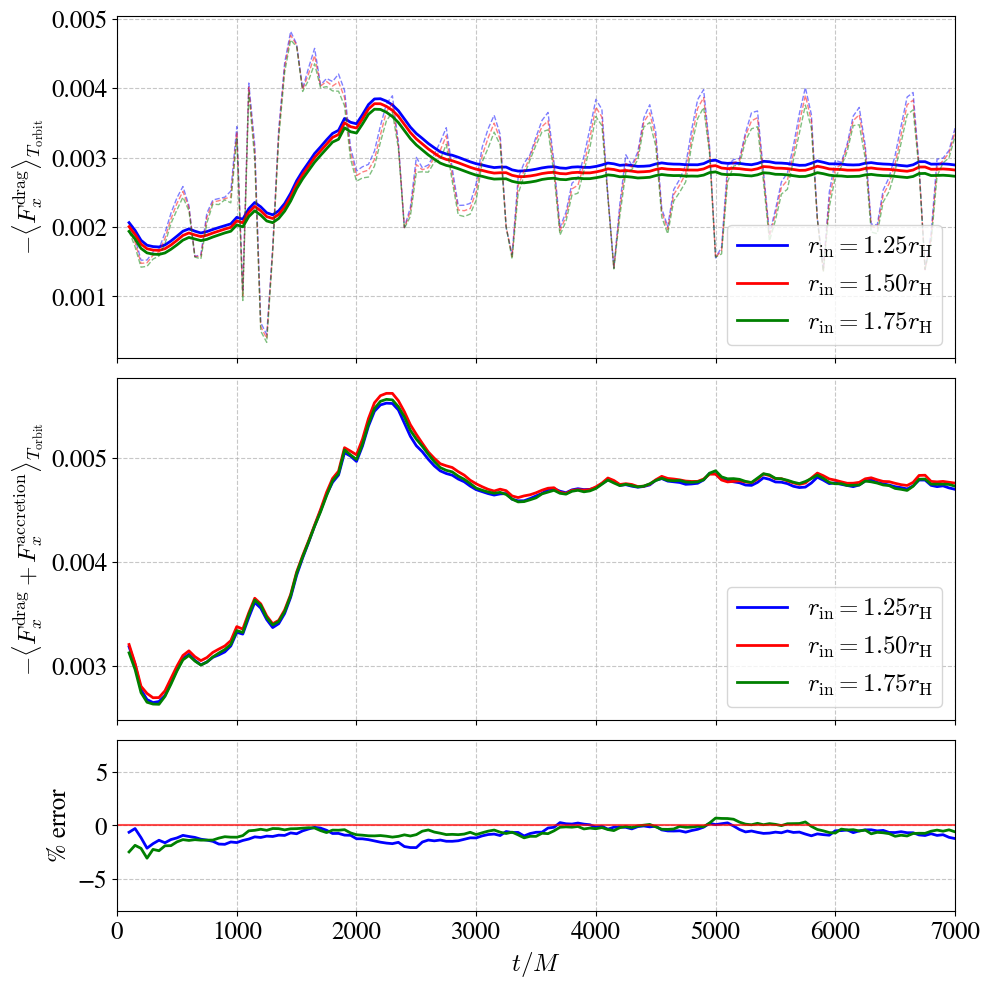

In [10]:
# Import scipy's interpolation function
from scipy.interpolate import interp1d

# Create a three-panel figure
fig_fontsize = 18
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), sharex=True, 
                                   gridspec_kw={'height_ratios': [1, 1, 0.5]})

# Define colors for different excise factors
colors = ['b', 'r', 'g']

# Dictionary to store drag force data for each excise factor
drag_data = {}

# Panel 1: Drag force with time-smoothing (from drag force analysis)
for i, ef in enumerate(excise_factors):
    if ef not in data:
        continue
    
    results = data[ef]['volume']
    results_sur = data[ef]['surface']
    
    dt = results[1,0] - results[0,0]
    window_size = int(T_orbit/dt)  # Smooth over one orbital period
    
    # Create smoothed array for drag force
    smoothed_drag = np.zeros_like(results[:,1])
    
    # Handle the main part where full window is available
    valid_smoothed = np.convolve(results[:,1], np.ones(window_size)/window_size, mode='valid')
    smoothed_drag[window_size-1:window_size-1+len(valid_smoothed)] = valid_smoothed
    
    # Handle left boundary (beginning of array)
    for j in range(window_size-1):
        curr_window = j + 1
        smoothed_drag[j] = np.sum(results[:curr_window,1]) / curr_window
    
    # Store time and smoothed drag for error calculation
    drag_data[ef] = {
        'time': results[:,0],
        'smoothed_drag': -smoothed_drag  # Store the negative value for consistency
    }
    
    # Plot raw data with dashed lines
    ax1.plot(results[:,0], -results[:,1], 
             linestyle='--', linewidth=1, color=colors[i], alpha=0.5)
    
    # Plot smoothed data with solid lines (no density normalization)
    ax1.plot(results[:,0], -smoothed_drag, 
             linestyle='-', linewidth=2, color=colors[i], 
             label="$r_{\\text{in}} = %.2f r_{ \\text{H}}$" % ef)

# Panel 2: Net Force X (from time-smoothed net force analysis)
net_force_data = {}

for i, ef in enumerate(excise_factors):
    if ef not in data:
        continue
    
    results = data[ef]['volume']
    results_sur = data[ef]['surface']
    
    dt = results[1,0] - results[0,0]
    window_size = int(T_orbit/dt)
    
    # Calculate net force in X direction
    net_force_x = (results_sur[:, 4] + results_sur[:, 7])/np.pi - results[:, 1]
    
    # Create smoothed array for net force
    smoothed_net_force_x = np.zeros_like(net_force_x)
    
    # Apply smoothing where full window is available
    valid_smoothed_x = np.convolve(net_force_x, np.ones(window_size)/window_size, mode='valid')
    smoothed_net_force_x[window_size-1:window_size-1+len(valid_smoothed_x)] = valid_smoothed_x
    
    # Handle left boundary (beginning of array)
    for j in range(window_size-1):
        curr_window = j + 1
        smoothed_net_force_x[j] = np.sum(net_force_x[:curr_window]) / curr_window
    
    # Store time and smoothed net force for error calculation
    net_force_data[ef] = {
        'time': results[:,0],
        'smoothed_net_force': smoothed_net_force_x
    }
    
    # Plot smoothed net force X
    ax2.plot(results[:,0], smoothed_net_force_x, 
             linestyle='-', linewidth=2, color=colors[i], 
             label="$r_{\\text{in}} = %.2f r_{ \\text{H}}$" % ef)

# Panel 3: Percentage error relative to r_in = 1.5 r_H
baseline_ef = 1.5  # Use 1.5 r_H as the baseline case

if baseline_ef in net_force_data:
    baseline_time = net_force_data[baseline_ef]['time']
    baseline_net_force = net_force_data[baseline_ef]['smoothed_net_force']
    
    # Plot percentage errors for net force (drag + accretion)
    for i, ef in enumerate(excise_factors):
        if ef != baseline_ef and ef in net_force_data:
            # Get data for this excise factor
            current_time = net_force_data[ef]['time']
            current_net_force = net_force_data[ef]['smoothed_net_force']
            
            # Create interpolation function with extrapolation for out-of-bounds points
            interp_func = interp1d(current_time, current_net_force, bounds_error=False, fill_value="extrapolate")
            
            # Interpolate to match baseline time points
            interpolated_net_force = interp_func(baseline_time)
            
            # Calculate relative difference
            rel_diff = (interpolated_net_force - baseline_net_force) / baseline_net_force * 100
            
            # Plot on the third subplot
            ax3.plot(baseline_time, rel_diff, color=colors[i], 
                    linewidth=2, label=f'$r_{{in}} = {ef} r_H$')
    
    # Add horizontal line at zero (use red to mark the baseline)
    ax3.axhline(y=0, color='r', linestyle='-', alpha=0.7, linewidth=1.5)

# Configure first subplot (drag force)
ax1.set_ylabel(r'$-\langle F^{\mathrm{drag}}_x \rangle_{T_{\mathrm{orbit}}}$', fontsize=fig_fontsize)
ax1.legend(fontsize=fig_fontsize, loc='lower right')
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.tick_params(labelsize=fig_fontsize)
ax1.set_xlim(0, 7000)  # Set x limit to 0-7000

# Configure second subplot (net force)
ax2.set_ylabel(r'$-\langle F^{\mathrm{drag}}_x + F^{\mathrm{accretion}}_x \rangle_{T_{\mathrm{orbit}}}$', fontsize=fig_fontsize)
ax2.legend(fontsize=fig_fontsize, loc='lower right')
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.tick_params(labelsize=fig_fontsize)
ax2.set_xlim(0, 7000)  # Set x limit to 0-7000

# Configure third subplot (error)
ax3.set_xlabel('$t/M$', fontsize=fig_fontsize)
ax3.set_ylabel('% error', fontsize=fig_fontsize)
ax3.grid(True, linestyle='--', alpha=0.7)
ax3.tick_params(labelsize=fig_fontsize)
ax3.set_ylim(-8, 8)  # Set reasonable y-limit for error percentage
ax3.set_xlim(0, 7000)  # Set x limit to 0-7000

# Adjust layout
plt.tight_layout()
plt.savefig(f"accretion_drag_rin_convergence.pdf", bbox_inches='tight')
plt.show()
